In [16]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [17]:
def preprocess_dataset(dataset_path, img_size):
    images = []
    labels = []

    for dirname, _, filenames in os.walk(dataset_path):
        for filename in filenames:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                file_path = os.path.join(dirname, filename)

                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, img_size)  # Resize image
                images.append(img)

                label = os.path.basename(dirname)
                labels.append(label)

    images = np.array(images, dtype=np.float32) / 255.0
    labels = np.array(labels)

    unique_labels = np.unique(labels)
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    encoded_labels = np.array([label_map[label] for label in labels])


    X_train, X_temp, y_train, y_temp = train_test_split(images, encoded_labels, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    # Expand dimensions
    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    return X_train, X_val, X_test, y_train, y_val, y_test, label_map


In [18]:
def preprocess_datasets(paths, img_size):
    images = []
    labels = []

    for path_info in paths:
        base_path = path_info['base_path']
        real_folder = path_info['real_folder']
        forge_folder = path_info['forge_folder']

        real_path = os.path.join(base_path, real_folder)
        for img_name in os.listdir(real_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                file_path = os.path.join(real_path, img_name)
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append('real')

        forge_path = os.path.join(base_path, forge_folder)
        for img_name in os.listdir(forge_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                file_path = os.path.join(forge_path, img_name)
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append('forge')

    images = np.array(images, dtype=np.float32) / 255.0
    labels = np.array(labels)

    unique_labels = np.unique(labels)
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    encoded_labels = np.array([label_map[label] for label in labels])

    X_train, X_temp, y_train, y_temp = train_test_split(images, encoded_labels, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    return X_train, X_val, X_test, y_train, y_val, y_test, label_map

In [19]:
def make_pairs(images, labels):
    pairImages = []
    pairLabels = []
    numClasses = len(np.unique(labels))

    idx = [np.where(labels == i)[0] for i in range(numClasses)]

    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]

        if label < 0 or label >= numClasses:
            continue

        if len(idx[label]) > 0:
            idxB = np.random.choice(idx[label])
            posImage = images[idxB]
            pairImages.append([currentImage, posImage])
            pairLabels.append([1])

        negIdx = np.where(labels != label)[0]
        if len(negIdx) > 0:
            negImage = images[np.random.choice(negIdx)]
            pairImages.append([currentImage, negImage])
            pairLabels.append([0])

    return np.array(pairImages), np.array(pairLabels)


In [20]:
def cnn_network(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    return Model(inputs, x, name="Base_CNN")

def siamese_network(input_shape):
    base_network = cnn_network(input_shape)
    img_a = layers.Input(shape=input_shape, name="Input_A")
    img_b = layers.Input(shape=input_shape, name="Input_B")
    feat_vecs_a = base_network(img_a)
    feat_vecs_b = base_network(img_b)
    distance = layers.Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]), name="L1_Distance")([feat_vecs_a, feat_vecs_b])
    outputs = layers.Dense(1, activation='sigmoid', name="Similarity_Output")(distance)
    return Model(inputs=[img_a, img_b], outputs=outputs, name="Siamese_Network")


In [21]:
def train_and_evaluate(X_train, X_val, X_test, y_train, y_val, y_test):
    input_shape = X_train.shape[1:]
    siamese = siamese_network(input_shape)
    siamese.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    unique_labels = np.unique(y_train)
    label_map = {label: idx for idx, label in enumerate(unique_labels)}
    y_train = np.array([label_map[label] for label in y_train])
    y_val = np.array([label_map[label] for label in y_val])
    y_test = np.array([label_map[label] for label in y_test])

    print("Generating image pairs...")
    pairTrain, labelTrain = make_pairs(X_train, y_train)
    pairVal, labelVal = make_pairs(X_val, y_val)
    print("Pair shapes:")
    print("Train pairs:", pairTrain.shape)
    print("Validation pairs:", pairVal.shape)

    img1_train, img2_train = pairTrain[:, 0], pairTrain[:, 1]
    img1_val, img2_val = pairVal[:, 0], pairVal[:, 1]
    start_time = time.time()  
    history = siamese.fit(
        [img1_train, img2_train], labelTrain,
        validation_data=([img1_val, img2_val], labelVal),
        batch_size=16,
        epochs=15,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)]
    )
    training_time = time.time() - start_time 
    pairTest, labelTest = make_pairs(X_test, y_test)
    start_time = time.time()
    img1_test, img2_test = pairTest[:, 0], pairTest[:, 1]
    predictions = siamese.predict([img1_test, img2_test])
    binary_predictions = (predictions > 0.5).astype("int32")
    test_time = time.time() - start_time
    final_accuracy = accuracy_score(labelTest, binary_predictions)
    precision = precision_score(labelTest, binary_predictions)
    recall = recall_score(labelTest, binary_predictions)
    f1 = f1_score(labelTest, binary_predictions)

    print(f"Final Accuracy: {final_accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1 Score: {f1 * 100:.2f}%")
    print(f"Training completed in {training_time:.2f} seconds")
    print(f"Test Time: {test_time:.2f} seconds")
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title("Accuracy")
    plt.show()

In [22]:
 def show_sample_pairs_with_labels(images, labels, num_samples=5):

    plt.figure(figsize=(10, num_samples * 3))
    
    for i in range(num_samples):
        try:
            index = np.random.randint(0, len(images))  
            pair = images[index]
            label = labels[index]

            if label == 1:  
                img_a_label = "Real"
                img_b_label = "Real"
            elif label == 0: 
                img_a_label = "Real"
                img_b_label = "Forged"
            else:
                img_a_label = "Unknown"
                img_b_label = "Unknown"

            
            plt.subplot(num_samples, 2, i * 2 + 1)
            plt.imshow(pair[0].squeeze(), cmap='gray')
            plt.title(f"Image A ({img_a_label})")
            plt.axis('off')

        
            plt.subplot(num_samples, 2, i * 2 + 2)
            plt.imshow(pair[1].squeeze(), cmap='gray')
            plt.title(f"Image B ({img_b_label})")
            plt.axis('off')

        except Exception as e:
            print(f"Error displaying sample {i}: {e}")

    plt.tight_layout()
    plt.show()


Processing Dataset 1
Generating image pairs...
Pair shapes:
Train pairs: (3696, 2, 128, 128, 1)
Validation pairs: (792, 2, 128, 128, 1)
Epoch 1/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6461 - loss: 0.4451 - val_accuracy: 0.9343 - val_loss: 0.1508
Epoch 2/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9631 - loss: 0.1080 - val_accuracy: 0.9571 - val_loss: 0.1298
Epoch 3/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.9934 - loss: 0.0321 - val_accuracy: 0.9621 - val_loss: 0.1350
Epoch 4/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9802 - loss: 0.0672 - val_accuracy: 0.9457 - val_loss: 0.1608
Epoch 5/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9959 - loss: 0.0136 - val_accuracy: 0.9457 - val_loss: 0.1580
Epoch 6/15
231/231 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.9927 - loss: 0.0224 - val_accuracy: 0.9571 - val_loss: 0.0951
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Final Accuracy: 95.71%
Precision: 97.38%
Recall: 

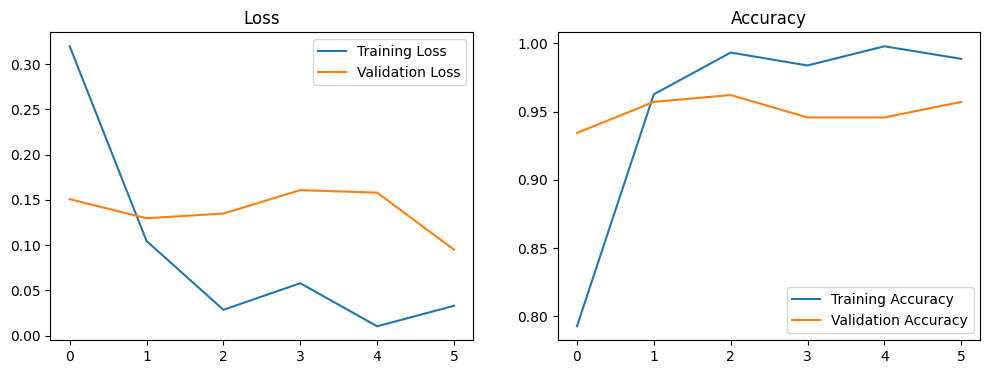

In [23]:
# Dataset 1
print("Processing Dataset 1")
dataset_path1 = '/kaggle/input/cedardataset'
X_train1, X_val1, X_test1, y_train1, y_val1, y_test1, label_map1 = preprocess_dataset(dataset_path1, (128, 128))
train_and_evaluate(X_train1, X_val1, X_test1, y_train1, y_val1, y_test1)

Samples from Dataset 1


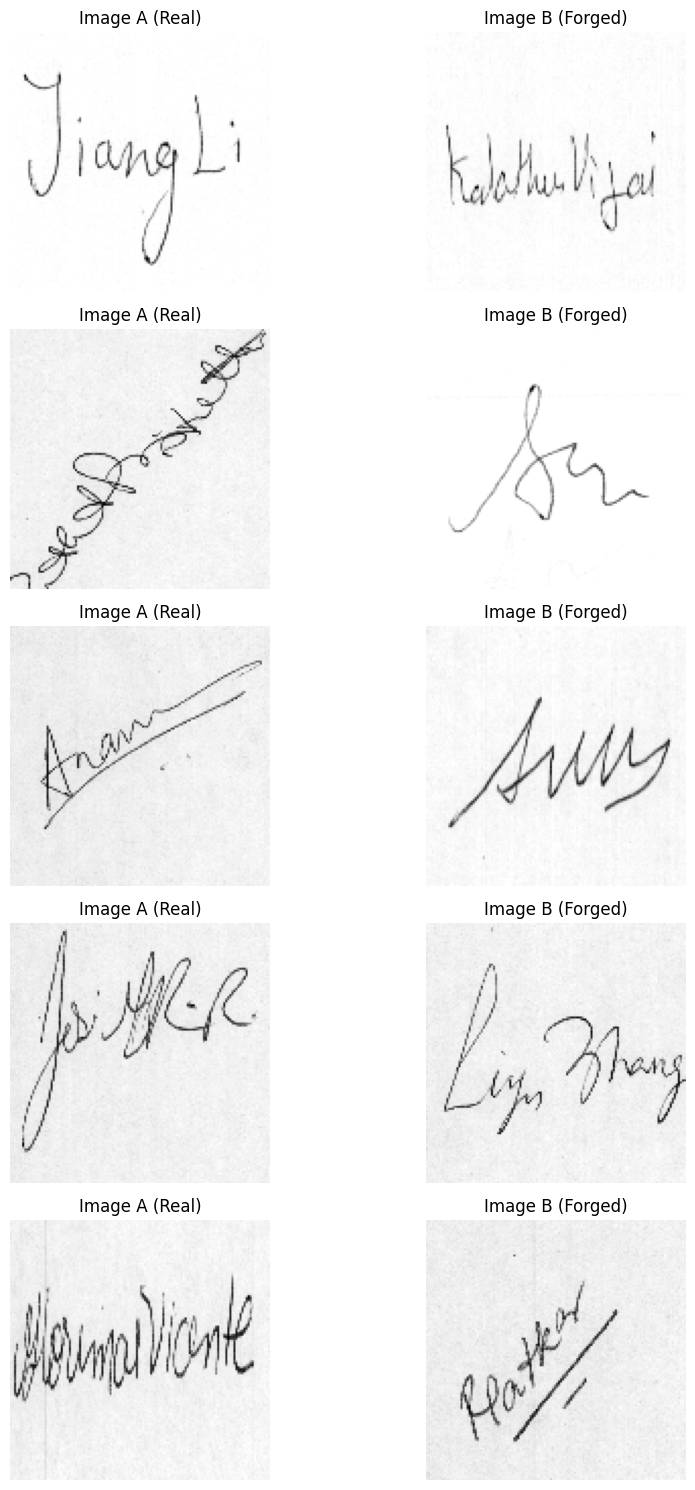

In [24]:
print("Samples from Dataset 1")
pairImages, pairLabels = make_pairs(X_train1, y_train1)
show_sample_pairs_with_labels(pairImages, pairLabels, num_samples=5)

Processing Dataset 2


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Generating image pairs...
Pair shapes:
Train pairs: (3008, 2, 256, 256, 1)
Validation pairs: (582, 2, 256, 256, 1)
Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - accuracy: 0.5786 - loss: 0.6204 - val_accuracy: 0.7990 - val_loss: 0.5026
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.8551 - loss: 0.3897 - val_accuracy: 0.8110 - val_loss: 0.5165
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 123ms/step - accuracy: 0.9414 - loss: 0.2192 - val_accuracy: 0.7887 - val_loss: 0.5363
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.9665 - loss: 0.1675 - val_accuracy: 0.7990 - val_loss: 0.7368
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.9846 - loss: 0.0857 - val_accuracy: 0.7938 - val_loss: 0.7480
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step
Final Accuracy: 80.99%
Precision: 83.54%
Recall: 77.19%
F1 Score: 80.24%
Training completed in 127.20 seconds
Test Time: 3.61 seconds


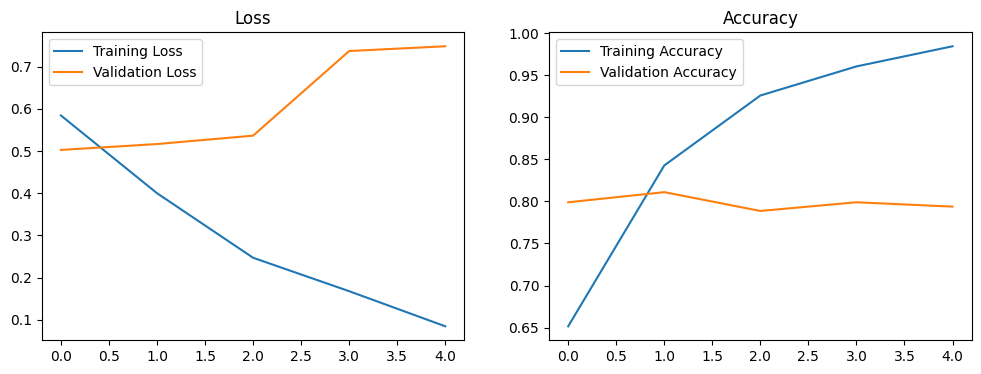

In [25]:
# Dataset 2
print("Processing Dataset 2")
dataset_path2 = '/kaggle/input/re-arranged-data'
X_train2, X_val2, X_test2, y_train2, y_val2, y_test2, label_map2 = preprocess_dataset(dataset_path2, (256, 256))
train_and_evaluate(X_train2, X_val2, X_test2, y_train2, y_val2, y_test2)

Samples from Dataset 2...


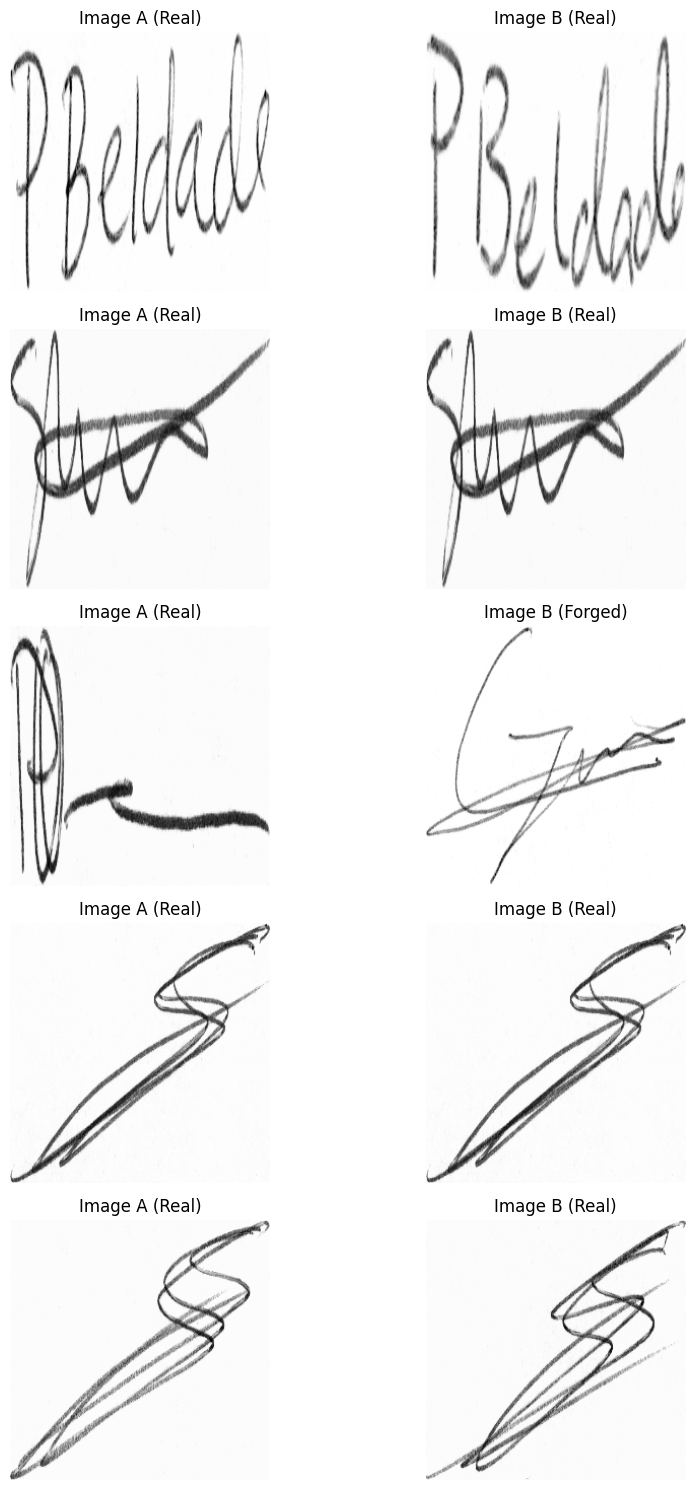

In [28]:
print("Samples from Dataset 2)
pairImages, pairLabels = make_pairs(X_train2, y_train2)
show_sample_pairs_with_labels(pairImages, pairLabels, num_samples=5)


In [29]:
import kagglehub
path = kagglehub.dataset_download("divyanshrai/handwritten-signatures")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/handwritten-signatures


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Generating image pairs...
Pair shapes:
Train pairs: (1008, 2, 256, 256, 1)
Validation pairs: (216, 2, 256, 256, 1)
Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.4549 - loss: 0.7343 - val_accuracy: 0.4815 - val_loss: 0.6940
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.5804 - loss: 0.6899 - val_accuracy: 0.4676 - val_loss: 0.6909
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.6224 - loss: 0.6712 - val_accuracy: 0.5046 - val_loss: 0.6931
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.6213 - loss: 0.6652 - val_accuracy: 0.5231 - val_loss: 0.6996
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.6882 - loss: 0.6080 - val_accuracy: 0.5509 - val_loss: 0.6956
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.7879 - loss: 0.5322 - val_accuracy: 0.5046 - val_loss: 0.7913
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 0.7657 - loss: 0.5324 - val_accuracy: 0.5278 - val_l

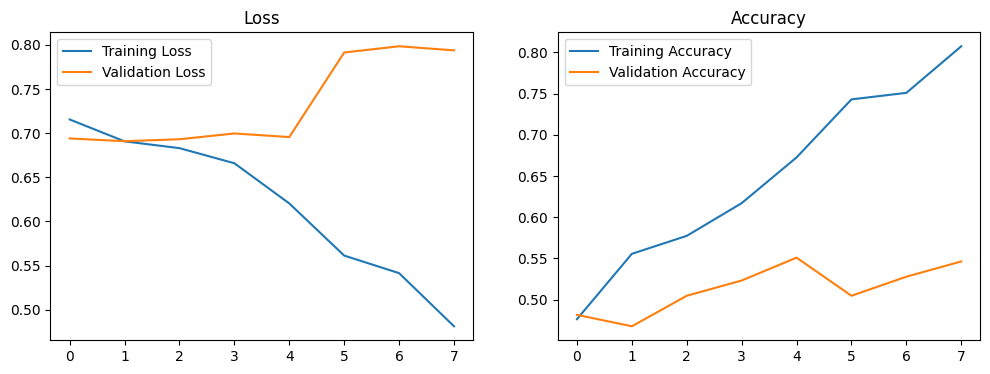

In [30]:
# Dataset 3
paths = [
    {'base_path': '/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset1', 'real_folder': 'real', 'forge_folder': 'forge'},
    {'base_path': '/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset2', 'real_folder': 'real', 'forge_folder': 'forge'},
    {'base_path': '/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset3', 'real_folder': 'real', 'forge_folder': 'forge'},
    {'base_path': '/kaggle/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset4', 'real_folder': 'real1', 'forge_folder': 'forge'}
]
img_size = (256, 256)
X_train3, X_val3, X_test3, y_train3, y_val3, y_test3, label_map3 = preprocess_datasets(paths, img_size)
train_and_evaluate(X_train3, X_val3, X_test3, y_train3, y_val3, y_test3)

Samples from Dataset 3


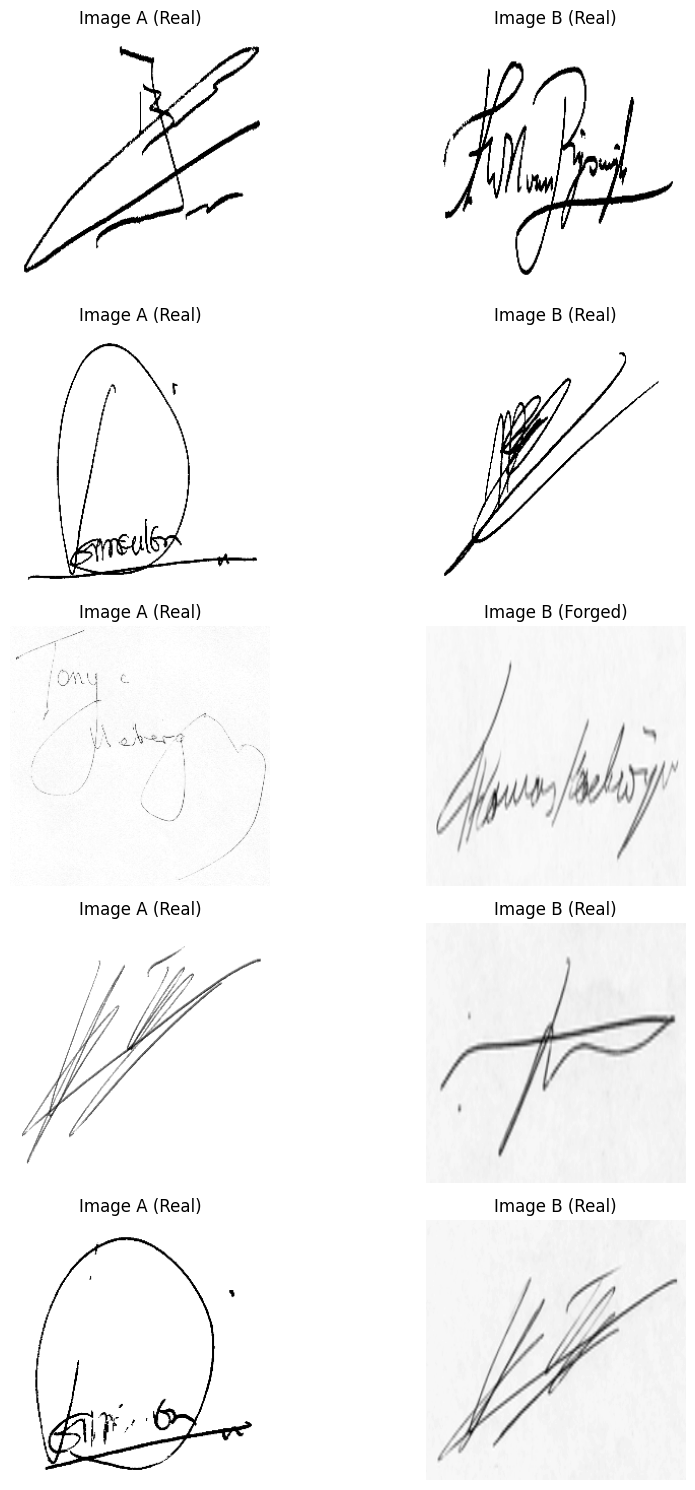

In [31]:
print("Samples from Dataset 3")
pairImages, pairLabels = make_pairs(X_train3, y_train3)
show_sample_pairs_with_labels(pairImages, pairLabels, num_samples=5)